In [1]:
!pip install -q tensorflowjs
!nvidia-smi

     |████████████████████████████████| 77 kB 2.9 MB/s 
     |████████████████████████████████| 462 kB 11.0 MB/s 
Tue Mar 22 12:25:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------------------

In [2]:
#@title Runtime
use_tpu = False #@param


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
import json
np.random.seed(0)

In [4]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)

features = np.concatenate((pos_data, neg_data), axis=0)

In [5]:
print('Positive data', pos_data.shape[0])
print('Negative data', neg_data.shape[0])

Positive data 1826
Negative data 7490


In [29]:
pos_data.shape

(1826, 190)

In [94]:
  @dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(labels), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )



In [95]:
print(L)

None


In [109]:
def build_model(L):
    inputs = tf.keras.Input(shape=(L,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    counts = tf.keras.layers.GlobalAveragePooling1D()(e)
    print(counts)


    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    # x = tf.keras.layers.Concatenate()([x, counts])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='sol-rnn')
    return model

def build_infer_model(L):
    inputs = tf.keras.Input(shape=(L,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    counts = tf.keras.layers.GlobalMaxPool1D()(e)


    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    # x = tf.keras.layers.Concatenate()([x, counts])
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='sol-rnn-infer')
    return model

In [110]:
if use_tpu:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.experimental.TPUStrategy(resolver)


In [111]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
data = tf.data.Dataset.from_tensor_slices((features, labels))
# now split into val, test, train and batch
N = len(data)  
L = None#features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [112]:
list(train_data)[0]

(<tf.Tensor: shape=(16, 190), dtype=int64, numpy=
 array([[ 2,  2, 11, ...,  0,  0,  0],
        [ 1, 11, 18, ...,  0,  0,  0],
        [ 1, 15,  1, ...,  0,  0,  0],
        ...,
        [14, 14,  6, ...,  0,  0,  0],
        [18, 14,  8, ...,  0,  0,  0],
        [14, 14,  2, ...,  0,  0,  0]])>,
 <tf.Tensor: shape=(16, 1), dtype=int64, numpy=
 array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0]])>)

In [113]:
tf.keras.backend.clear_session()
if use_tpu:
  with strategy.scope():
    model = build_model(L)
else:
  model = build_model(L)

  decay_epochs = 50
  decay_steps = N  // config.batch_size * decay_epochs
  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
  opt = tf.optimizers.Adam(lr_decayed_fn)
  model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='global_average_pooling1d/truediv:0', description="created by layer 'global_average_pooling1d'")


In [114]:
model.summary()

Model: "sol-rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 32)          672       
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 layer_normalization (LayerN  (None, 128)              256       
 ormalization)                                                   
                                                           

In [115]:
tf.keras.backend.clear_session()
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=10)],
    epochs=150)



lr = 0.001
Epoch 1/150
466/466 [==============================] - 35s 43ms/step - loss: 0.4966 - auc: 0.5854 - binary_accuracy: 0.7998 - val_loss: 0.4309 - val_auc: 0.7049 - val_binary_accuracy: 0.8228
lr = 0.000999368
Epoch 2/150
466/466 [==============================] - 13s 29ms/step - loss: 0.4690 - auc: 0.6687 - binary_accuracy: 0.8021 - val_loss: 0.4198 - val_auc: 0.7378 - val_binary_accuracy: 0.8228
lr = 0.0009974737
Epoch 3/150
466/466 [==============================] - 14s 29ms/step - loss: 0.4575 - auc: 0.7022 - binary_accuracy: 0.8012 - val_loss: 0.4231 - val_auc: 0.7311 - val_binary_accuracy: 0.8228
lr = 0.0009943218
Epoch 4/150
466/466 [==============================] - 14s 29ms/step - loss: 0.4491 - auc: 0.7198 - binary_accuracy: 0.8013 - val_loss: 0.4784 - val_auc: 0.7372 - val_binary_accuracy: 0.8195
lr = 0.0009899203
Epoch 5/150
466/466 [==============================] - 14s 29ms/step - loss: 0.4414 - auc: 0.7330 - binary_accuracy: 0.8037 - val_loss: 0.4232 - val_auc: 

59/59 [==============================] - 1s 11ms/step - loss: 0.4486 - auc: 0.7955 - binary_accuracy: 0.8185


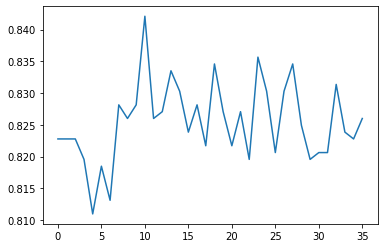

In [116]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate(test_data)
plt.show()

In [117]:
inference_model = build_infer_model(L)

inference_model.set_weights(model.get_weights())

In [118]:
inference_model(np.array([1,1,1,1]).reshape(1,-1))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.68244636]], dtype=float32)>